In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from wangdao_deeplearning_train import EarlyStopping, ModelSaver
from wangdao_deeplearning_train import plot_learning_loss_curves,train_regression_model,evaluate_regression_model
import os

In [3]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return (self.features[idx],self.features[idx][-2:]), self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


In [4]:
for i,j in train_loader:
    print(type(i))
    print(i)
    break

<class 'list'>
[tensor([[ 1.8522e+00, -2.8336e-01,  6.0165e-01, -1.8781e-01,  2.3047e-01,
         -1.0421e-02,  7.8882e-01, -1.2152e+00],
        [ 9.7737e-01, -1.9515e+00,  4.0831e-02,  1.4708e-02,  2.2187e+00,
         -9.4974e-02, -6.5464e-01,  3.8565e-01],
        [ 7.3815e-01, -4.5060e-02,  2.8460e-01, -2.4197e-01, -6.5880e-02,
         -2.1392e-02, -8.4210e-01,  7.3973e-01],
        [ 9.5282e-02, -7.5997e-01,  3.3098e-01, -3.2225e-02,  7.8975e-01,
         -1.3603e-01,  5.5449e-01, -1.1306e-01],
        [-5.1425e-01,  1.7025e+00,  4.1086e-02, -1.3789e-01, -2.7957e-01,
          4.0974e-02, -7.5774e-01,  6.3002e-01],
        [ 6.2533e-01, -1.1571e+00,  5.8349e-01, -2.1192e-01,  8.1174e-01,
         -1.8694e-02, -1.0624e+00,  1.1886e+00],
        [-3.8762e-01,  1.1381e-01,  6.6872e-01,  9.7540e-01, -2.9716e-01,
         -5.6317e-02, -3.9219e-01,  3.1583e-01],
        [-3.8963e-01, -1.2366e+00,  5.7954e-01,  4.7385e-02, -4.4137e-01,
         -5.3036e-02,  7.9819e-01, -4.8223e-02],


# 加载数据，构建模型

In [5]:
from torch import optim



# 定义神经网络模型
class WideDeepModel(nn.Module):
    def __init__(self, input_dim=(8,2)):
        super().__init__()
        # Deep部分使用Sequential
        self.deep = nn.Sequential(
            nn.Linear(input_dim[1], 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU()
        )
        
        # Wide部分直接使用原始输入
        
        # 输出层，输入维度是deep部分的30 + wide部分的input_dim
        self.output = nn.Linear(30 + input_dim[0], 1)
        
    def forward(self, x_wide, x_deep):
        # Deep路径，deep shape是[batch_size, 30]
        deep = self.deep(x_deep)
        
        # Wide路径直接使用原始输入
        wide = x_wide
        
        # 连接Wide和Deep,combined shape是[batch_size, 30 + input_dim[0]]
        combined = torch.cat([wide, deep], dim=1)
        
        # 输出层，输出shape是[batch_size, 1]
        output = self.output(combined)
        return output

# 初始化模型、损失函数和优化器
model = WideDeepModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 打印模型结构
print(model)

WideDeepModel(
  (deep): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=38, out_features=1, bias=True)
)


In [6]:
# 训练模型
# 初始化早停和模型保存对象
early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    print_every=10,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device
)

train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

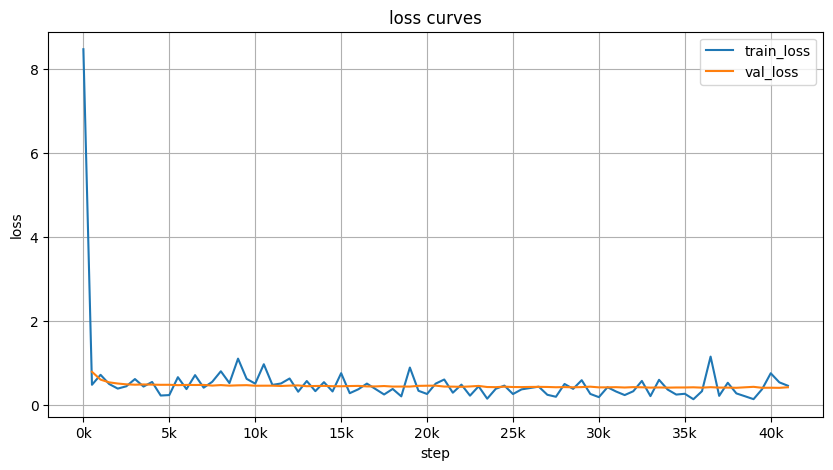

In [7]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.3868
